<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day5_am_morning/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# numpy syntax explanation
import numpy as np
array1D = np.array([1,2,3,4,5])
print("array1D\n",array1D)

transposed_array2D = array1D[:,np.newaxis]
print("\ntransposed_array2D\n",transposed_array2D)


array1D
 [1 2 3 4 5]

transposed_array2D
 [[1]
 [2]
 [3]
 [4]
 [5]]


#  Recurrent Neural Network
RNN is a supervised machine learning algorithm commonly used for sequential data tasks, such as natural language processing and time-series analysis (e.g. text generation and weather data). Inspired by the brain's neural connections, an RNN consists of interconnected nodes that process sequential data while retaining memory of previous inputs. The structure is very similar to other neural networks. RNN have weights, biases, layers and activation functions, but also feedback loop. The network's key components (recurrent connections  weights and biases) are adjusted during training to minimize the error between predicted and actual outputs. Due to their recurrent nature that allows information to persist across different time steps, RNN is good at capturing temporal patterns in sequential data.

### Import libraries and initialize random generator

In [3]:
import pandas as pd
import numpy as np
np.random.seed(0)

### Download data

In [4]:
!wget https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/master/data/clean_weather.csv

--2023-08-11 11:50:50--  https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/master/data/clean_weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406454 (397K) [text/plain]
Saving to: ‘clean_weather.csv’

clean_weather.csv   100%[===================>] 396.93K  --.-KB/s    in 0.04s   

2023-08-11 11:50:50 (10.8 MB/s) - ‘clean_weather.csv’ saved [406454/406454]



### Read Data from csv
In this tutorial, we will use RNN to predict future temperatures using sequences of weather observations. This data contains the Fahrenheit temperature and rain from 1970 to 2022. We will only use the `tmax` (max temperature) for now.


In [5]:
data = pd.read_csv("clean_weather.csv", index_col=0)
display(data)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


In [6]:
# fill missing values
data = data.ffill()
display(data)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


Each element in a sequence has a position.  We can think of those positions as being steps in time.  Here is a sequence of temperatures:


In [7]:
# Display a sequence of temperatures (first 10 days)
first_ten_max_temp = data["tmax"].head(10)
display(first_ten_max_temp)

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
1970-01-06    50.0
1970-01-07    52.0
1970-01-08    56.0
1970-01-09    54.0
1970-01-10    57.0
Name: tmax, dtype: float64

The sequence has 10 elements.  The first sequence element (at time step 0, or 1970 Jan 1) is `60`.  The second sequence element (at time step 1, or 1970 Jan 2) is `52`, and so on.

Let's say we want to predict the next element in the sequence (at time step `10`).  With a normal neural network, we have to treat each element in a sequence as a separate input feature, such as a CNN with 10 inputs. We could feed the above sequence as input into a neural network to predict the next temperature. However, such a CNN would only be able to take in sequences of size `10`. We want our network to be able to handle all of these inputs, even though they have different lengths. Moreover, these temperatures are all related. The temperature today affects the temperature tomorrow.  

## Visualize the data

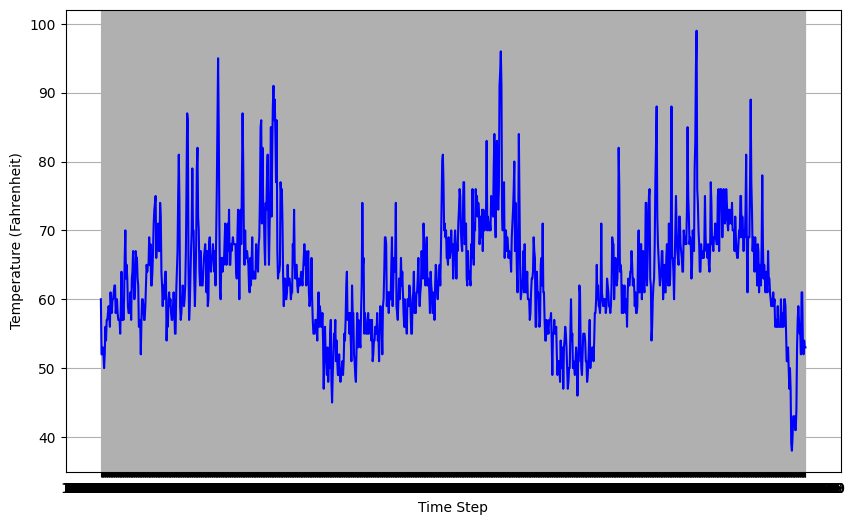

In [8]:
# graph the temperature for 3 years (from 1970 to 1973)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data["tmax"][0:365*3], color='blue')
plt.xlabel('Time Step')
plt.ylabel('Temperature (Fahrenheit)')
plt.grid(True)
plt.show()

## Rectified Linear Unit (ReLU) activation function
ReLU is defined as ReLU(x) = max(0, x), which means it returns the input value if it is positive and zero otherwise. ReLU introduces non-linearity to the network, enabling it to learn complex patterns and representations. The derivative of ReLU is 1 for positive inputs and 0 for negative inputs, making it computationally efficient to calculate gradients during the backpropagation process. We will see more activation functions later.

$$\text{ReLU}(x) = \max(0, x)$$

$$\frac{d}{dx} \text{ReLU}(x) =
\begin{cases}
      1 & \text{if } x > 0 \\
      0 & \text{if } x \leq 0
\end{cases}
$$

<img src="https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png" width="30%">



In [9]:
def relu(x):
    return np.maximum(0, x)

# RNN network structure
An RNN works by sharing parameters (weights and biases) throughout a sequence. To simplify its explanation, a recurrent neural network can be shown as follows:


![Rolled RNN](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/rnn_rolled.svg)

In this diagram, input data from a single time step is fed into the bottom of the RNN. It then goes through the input step (I) and the hidden step (H) before reaching the output step (O), which provides a prediction for the next element in the sequence.

The arrow connecting H to itself is called recurrence.  It means that the hidden layers are connected to each other across sequence steps.  To see how this works, let's see the expanded representation of an RNN:

![Unrolled RNN](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/rnn_unrolled.svg)

Every temperature for a day is an element. Each sequence element is labeled at the bottom with the time step of the element.  The first element in the sequence is `t0` (which is the first day), the second is `t1` (second day), and so on.  You can see that each element is passed into the input step, then to the hidden step.  But the output of the hidden step is passed both to the output, and to the next hidden step.

This means that at each step, the RNN retains information about the inputs from previous steps.  The "memory" of the network is stored in the hidden step (H), and represented as an internal matrix of values.  This matrix is continually updated at each time step, taking new information about the sequence.

## RNN Operations
We will see an example of the exact operations that happen at each step in an RNN:

An RNN has 3 steps:
- Input: take in a sequence item (temperature of a day), and multiply it by the input weight.
- Hidden: Take the previous hidden state, and multiply it by the hidden weight.  Add it to the input, then apply a nonlinear activation function.
- Output weight: Take the hidden state, and multiply by the output weight.

We also add in biases at the hidden and output steps, but the biases are left off the diagram to make it easier to read.

![Unrolled RNN](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/rnn_operations.svg)

The hidden state of the RNN stores information about previous sequence elements, which enables it to have memory.

This way, the RNN can have knowledge of past elements in the sequence without having separate parameters for each sequence item.  This is called parameter sharing - the RNN shares the same set of input, hidden, and output weights for every sequence element.

Therefore, RNN can take inputs of any length. This makes RNN more suitable for sequential data. For example, in text generation models, this allows us to predict the next word that came after a prompt, even if we don't know the length of the prompt beforehand.


## Feed forward manual simplified example
Below shows a manual example of feed forward. It is not our final model, and is only to show the basic structure of RNN. We'll initialize each weight matrix, then do a sample feed forward with 3 sequence elements.
We will initialize our network parameters using the numpy `random.rand` function to randomly create parameter matrices of a certain shape.  This network will take in a single input feature, turn it into `2` hidden features, and output one prediction.


In [10]:
# Take the input number and turn it into 2 features
i_weight = np.random.rand(1,2)
# Hidden to hidden weight connection - 2 features to 2 features
h_weight = np.random.rand(2,2)
# Output weight connection - turn 2 features into one prediction
o_weight = np.random.rand(2,1)

We will use the last 3 day temperatures as the input.

In [11]:
# Get 3 temperature values from our data
temps = data["tmax"].tail(3).to_numpy()
print(temps)

[66. 70. 62.]


We'll reshape each input value into a `1x1` matrix to make multiplication more convenient.

In [12]:
# Assign the sequence input at each time step to a different variable.
# x0 means input at time step 0
# Ensure that each element is a 1x1 matrix, so we can multiply it
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)
print(x0)

[[66.]]


Now we feed the element at day 0 into our network:

In [13]:
# Calculate xi at time step 0
xi_0 = np.dot(x0,i_weight)

# There is no previous time step, so there is no hidden state
# apply relu over the input to get the hidden state for time step 0 xh_0
xh_0 = relu(xi_0)

# Get the output at time step 0 xo_0
xo_0 = np.dot(xh_0, o_weight)

print(xo_0)

[[57.94406231]]


`xo_0` is our prediction for the next step in the sequence.

We can then move the network forward to time step `1` (next day's temperature):

In [14]:
# We feed the input in the same way as the previous time step
xi_1 = np.dot(x1, i_weight)

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_0 by the hidden weights
xh = np.dot(xh_0, h_weight)

# We add the previous hidden state (times h_weight) to the input at time step 1
xh_1 = relu(xh + xi_1)

# We again find the output by multiplying xh_1 by the output weight
xo_1 = np.dot( xh_1 ,o_weight)

print(xo_1)

[[124.54916092]]


`xo_1` is our prediction for the next sequence element.  Now we can do the same for our final time step 2 (the third day):

In [15]:
# We feed the input in the same way as the previous time step
xi_2 = np.dot(x2, i_weight)

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = np.dot(xh_1, h_weight)

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = relu( xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = np.dot(xh_2, o_weight)

print(xo_2)

[[190.94853131]]


Now we finished passing through 3 forward steps of RNN. The output `xo` at each time step is the prediction for the next element in the sequence. The last output `xo_2` is the prediction for x3, which is the fourth day.

The hidden state of the RNN allows the network to have information about all past sequence elements.  So when we're processing the sequence item at time step 2, the hidden state of the RNN stores information about the sequence elements at time step `0` and `1`.

## Issue of hidden state value increasing with time

We can notice that the output values increased in each time step of our RNN. That's because the hidden states kept getting larger and larger.  Unlike the sigmoid or softmax activation functions, relu doesn't change the scale of the inputs at all (it just sets some to 0).  This means that some values get repeatedly multiplied and grow larger and larger.

We can see that our hidden state at time step 2 is much larger than the initial hidden state

In [16]:
xh_0

array([[36.22169126, 47.20249818]])

In [17]:
xh_2

array([[124.88411227, 152.84252918]])

## Tanh activation function
To fix this, we usually use the $\tanh$ activation function for RNNs.  

The hyperbolic tangent is an activation function commonly used in neural networks. It maps the input values to the range (-1, 1), making it a good choice for normalization and handling data with negative and positive values. The tanh function is defined as:

$$ \text{tanh}(x) = \frac{{e^x - e^{-x}}}{{e^x + e^{-x}}} $$

<img src="
https://mathworld.wolfram.com/images/interactive/TanhReal.gif" width="30%">



As x gets large, $e^{x}$ gets very big, and $e^{-x}$ gets very small.  This pushes the output of $\tanh$ towards `1`.  When x gets very small (negative), $e^{-x}$ gets very large, and $e^{x}$ gets very small.  This results in `-1`.

$\tanh$ outputs values between `-1` and `1`.  It also has a very steep slope before and after `0` on the x-axis.  The tanh activation function is better for our purposes than sigmoid because it enables us to have negative values.  This enables the gradient to be steeper, which aids in gradient descent.




$$ \frac{{d}}{{dx}} \text{{tanh}}(x) = 1 - \text{{tanh}}^2(x) $$

The derivative has a steep slope, making it ideal as an activation function - this will enable gradient descent to descend effectively.  We can now use $\tanh$ instead of relu in our network.

In [18]:
def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1- np.tanh(x)**2

def tanh_prime_y(y):
  return 1- y**2

## Feed Forward (full)

We'll first initialize our weights and biases.  We only have bias terms in the hidden and output steps.

We'll also scale the weights and biases to work properly with the $\tanh$ nonlinearity.  We'll make our input and hidden weights small, so $\tanh$ doesn't squash all the values to `1` or `-1`.  We'll make the output weight large, since the output of the hidden step will be small (between `1` and `-1`). This step is optional, since the network would eventually learn the correct parameters.  However, initializing weights and biases to the correct ranges will help gradient descent to minimize the errors faster.

In [19]:
# Define our weights and biases
# Scale them down so values get through the tanh nonlinearity
i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1
print(i_weight)
print(h_weight)
print(h_bias)

[[ 0.09273255 -0.0233117   0.05834501  0.00577898  0.01360891]]
[[ 0.08511933 -0.08579279 -0.08257414 -0.09595632  0.06652397]
 [ 0.05563135  0.07400243  0.09572367  0.05983171 -0.00770413]
 [ 0.05610584 -0.07634511  0.0279842  -0.07132934  0.08893378]
 [ 0.00436966 -0.01706761 -0.04708888  0.05484674 -0.00876993]
 [ 0.01368679 -0.09624204  0.0235271   0.02241914  0.0233868 ]]
[[ 0.08874962  0.03636406 -0.02809842 -0.01259361  0.03952624]]


In [20]:
# Tanh pushes values to between -1 and 1, so scale up the output weights
o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)
print(o_weight)
print(o_bias)

[[ 3.01127358]
 [33.33833577]
 [33.53189348]
 [10.51912805]
 [ 6.44631488]]
[[0.31542835]]


Then we can write the feed forward as a for loop.  This loop will process sequence elements one by one.  We'll store the output prediction and the hidden state:

In [21]:
# An array to store the output predictions
outputs = np.zeros(3)
# An array to store hidden states for use in backpropagation
hiddens = np.zeros((3, 5))

# This will store the previous hidden state, since we'll need it to calculate the current hidden step
prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()
print(sequence)

[66. 70. 62.]


This network will take in a single input feature, turn it into 5 hidden features, and output one prediction.

In [22]:
for i in range(3):
    # Get the input sequence at the given position
    x = sequence[i].reshape(1,1)

    # Multiply input by input weight
    xi = np.dot(x, i_weight)
    if prev_hidden is not None:
        # Add previous hidden to input
        xh = xi + np.dot(prev_hidden, h_weight) + h_bias
    else:
        xh = xi

    # Apply the activation function
    xh = tanh(xh)
    prev_hidden = xh
    hiddens[i,] = xh

    # Multiply by the output weight
    xo = xh @ o_weight + o_bias
    outputs[i] = xo

Afterwards, we can take a look at our outputs and hidden states.  As we can see, the hidden states don't increase constantly anymore:

In [23]:
outputs

array([14.86774839, 12.40024082, 12.15491489])

In [24]:
hiddens

array([[ 0.99999034, -0.91188009,  0.99909615,  0.3639339 ,  0.71541453],
       [ 0.99999686, -0.95624332,  0.99920323,  0.2032835 ,  0.82365943],
       [ 0.9999861 , -0.93840768,  0.99799829,  0.14974186,  0.78700449]])

## Loss function: Mean Square Error
Currently our model is making random predictions. To make it better (which is training) we need to first be able to measure its performance during training. Therefore, we need a loss function. The Mean Squared Error (MSE) is a common metric used to evaluate the performance of a regression model. It measures the average squared difference between the predicted values and the actual values in a dataset. By squaring the differences, the MSE penalizes large errors more heavily, emphasizing the importance of accurate predictions.

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
- $n$ is the number of data points in the dataset.
- $y_i$ represents the actual (observed) value of the dependent variable for the $i$-th data point.
- $\hat{y}_i$ represents the predicted value of the dependent variable for the $i$-th data point.

A lower MSE value indicates that the model's predictions are closer to the actual values, meaning a better fit of the model to the data. A higher MSE value indicates larger prediction errors and a poorer model fit.

After we do our feed forward, we can calculate the gradient with respect to the network outputs using `mse_gradient`

In [25]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_gradient(actual, predicted):
    return predicted - actual

In [26]:
# Actual next day temperatures
actuals_temperatures = np.array([70, 62, 65])

loss_grad = mse_gradient(actuals_temperatures, outputs)
print(loss_grad)

[-55.13225161 -49.59975918 -52.84508511]


## Back Propagation
With the loss function, we can calculate the error of the model. To minimize the error, we will use back propagation to updating our model parameters, just like other neural networks. The main difference in RNN is that parameters impact both the current output and future outputs.

The last hidden step is only used by the output of the last time step, so adjusting the last step is the same as normal neural networks like CNN.

![last hidden](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/gradient_last.svg)

But this is different for other hidden steps. The hidden step at time step 2 is connected to both the output and the next hidden state.  So it affects not just the current output, but all subsequent outputs.

![prev hidden](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/gradient_inside.svg)

We'll have to send the gradient with respect to each hidden step backwards to the previous sequence position.  This is called backpropagation through time, and it's how we train the parameters of an RNN.
![rnn backward](https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/81cf89f68143535b7361990aa0fc49d253399c65/explanations/images/rnn/rnn_operations_bw.svg)


## Back propagation manual simplified example
Below shows the back propagation process step by step for each sequence element.

We first create variables to store the gradients with respect to each parameter, because we want to add up the gradients across time positions before making updates with gradient descent.

In [27]:
# These will keep a running total of the gradients
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0, 0, 0, 0,0 ]

We start at the end and run backpropagation for the last sequence element.  In this case, there is no next hidden state, so we only need to worry about the gradient with respect to the output at the last step

In [28]:
# Get the loss with respect to the output at the current time step
l2_grad = loss_grad[2].reshape(1,1) # layer2's gradient is the last item of the loss gradient

# Multiply the output of the transposed hidden step by the l2 gradient
# np.newaxis creates a new size 1 axis, effectively transposing the hiddens
o_weight_grad += np.dot(hiddens[2][:,np.newaxis], l2_grad)
# Add to the bias gradient.  Similar to CNN, this is just the mean of the l2_grad.
o_bias_grad += np.mean(l2_grad)

# Find the gradient wrt the hidden step output
h2_grad = np.dot(l2_grad, o_weight.T)

# Derivative of the tanh function
tanh_deriv = tanh_prime_y(hiddens[2,:][np.newaxis,:])
# Multiply each position in the h_grad by the tanh derivative - this "undoes" the tanh in the forward pass
h2_grad = np.multiply(h2_grad, tanh_deriv)

# Find how much we need to update the hidden weights by taking the input to the
# hidden step (the output of the previous hidden step in the forward pass) @ h2_grad
h_weight_grad += np.dot(hiddens[1,:][:,np.newaxis], h2_grad)
h_bias_grad += np.mean(h2_grad)

# This multiples the sequence value at time step 2 by the gradient
i_weight_grad += np.dot(sequence[2].reshape(1,1).T, h2_grad)

A lot of the above step is very similar to CNN backpropagation.  The main difference comes in the next sequence position (1) where we need to consider multiple gradients at the hidden step:

In [29]:
# Get the loss with respect to the output at the current time step
l1_grad = loss_grad[1].reshape(1,1)

# Multiply the output of the transposed hidden step by the l1 gradient
o_weight_grad += np.dot(hiddens[1][:,np.newaxis], l1_grad)
# Add to the bias gradient.  Similar to CNN, this is just the mean of the l1_grad.
o_bias_grad += np.mean(l1_grad)

# Find the gradient wrt the hidden step output
h1_grad = np.dot(l1_grad, o_weight.T)

# The above operations are all the same

# We do have a next sequence position (2), so we need to include that gradient
# We multiply the h2 gradient by the weight to pull it back to the current sequence position
h1_grad += np.dot(h2_grad , h_weight.T) # new for layer 1

# The rest of the operation is the same
tanh_deriv = tanh_prime_y(hiddens[1,:][np.newaxis,:])
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hiddens[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += sequence[1].reshape(1,1).T @ h1_grad

Now, we can do the final sequence position, 0.  The main difference here is that we don't update the hidden gradient, since there is no previous sequence position that gave us hidden state input in the forward pass:

In [30]:
l0_grad = loss_grad[0].reshape(1,1)

o_weight_grad += np.dot(hiddens[0][:,np.newaxis], l0_grad)
o_bias_grad += np.mean(l0_grad)

h0_grad = np.dot(l0_grad , o_weight.T)

h0_grad += np.dot(h1_grad , h_weight.T)

tanh_deriv = tanh_prime_y(hiddens[0,:][np.newaxis,:])
h0_grad = np.multiply(h0_grad, tanh_deriv)

# We don't update the hidden weight, since there was no previous hidden state
# We can update the hidden bias if you want

i_weight_grad += np.dot(sequence[0].reshape(1,1).T, h0_grad)

We can now look at our gradient updates:

In [31]:
i_weight_grad

array([[-4.52649110e-01, -4.41352398e+04, -8.35799697e+02,
        -1.05017331e+05, -2.65832538e+04]])

We've now completed backpropagation across 3 time steps!  We'll see how to make the gradient updates in the next section.

## Backward Propagation using loopps

Similar to the feed forward, we can implement the full backward pass as a loop.  Here it is:

In [32]:
next_hidden = None # we don't have a hidden state after the last layer, so it start as none

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0,0,0,0,0]

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    # Only add in the hidden gradient if a next sequence exists
    if next_hidden is not None:
        h_grad = o_grad + next_hidden @ h_weight.T
    else:
        h_grad = o_grad

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    # Don't update the hidden weights for the first sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

We can then use gradient descent to make parameter updates:

In [33]:
lr = 1e-6
# We'll divide the learning rate by the sequence length, since we were adding together the gradients
# This makes training the model more stable
lr = lr / 3

i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

## Combining all code together
RNN uses gradient descent just like many other models.
1. Randomly initialize the parameters (weights and biases).
2. Compute the gradient of the cost function in respect to the weights and biases
3. We use this gradient to update the weights and biases (minus the weights and biases by the gradients times a tiny number called learning rate)
4. Repeat for as many times as time and computation resource permits

## Prepare data
We will use max temperature, min temperature, and rain to predict future temperatures

In [34]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, validation, test sets
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

Then we can initialize our weights and biases.  We'll scale our parameters so they are relatively small.  This helps the network descend better:

In [35]:
def initialize_weights_and_biases(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        k = 1/math.sqrt(layer_conf[i]["hidden"])

        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"])
        i_weight = (i_weight-0.5)*2*k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"])
        h_weight = (h_weight-0.5)*2*k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"])
        h_bias = (h_bias-0.5)*2*k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"])
        o_weight = (o_weight-0.5)*2*k
        o_bias = np.random.rand(1, layer_conf[i]["output"])
        o_bias = (o_bias-0.5)*2*k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [47]:
x_variable_counts=3 # we have 3 variable used to predict future weather (max temperature, min temperature, and rain)

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1, "units":1}
]
layers = initialize_weights_and_biases(layer_conf)
print(layers) # a list of layers, which every layer contains [i_weight, h_weight, h_bias, o_weight, o_bias]

[[array([[-0.03642458, -0.22237129,  0.08678435,  0.36385561],
       [-0.38246814,  0.01737911, -0.36793189,  0.21685968],
       [-0.1039403 ,  0.06542131, -0.31672016, -0.35515224]]), array([[-0.01194372, -0.14438726,  0.44043195,  0.26532525],
       [ 0.24866362,  0.40371974, -0.41657756,  0.05219247],
       [ 0.08447607,  0.46193638, -0.20785247, -0.25917122],
       [-0.39970606, -0.48357037,  0.42952932,  0.16991655]]), array([[ 0.28515291, -0.21826989,  0.08641017, -0.43604473]]), array([[-0.0143724 ],
       [ 0.47749514],
       [ 0.37650525],
       [-0.16184105]]), array([[0.46157015]])]]


Then we'll write a forward pass:

In [48]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for layer in layers: # go over each layers
        i_weight, h_weight, h_bias, o_weight, o_bias = layer # unpack the parameters of the current layer

        # initialize the hidden and output matrices as zeros
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))

        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:]  # take the j-th row of the temperature data, and convert it to a 2D row matrix (so we can perform maxtrix multiplications later)
            input_x = np.dot(input_x, i_weight)
            hidden_x = input_x + np.dot(hidden[max(j-1,0),:][np.newaxis,:], h_weight) + h_bias

            # Activation function to avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            hidden[j,:] = hidden_x # Store hidden for use in backprop

            # Output layer
            output_x = np.dot(hidden_x, o_weight) + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

And a backward pass:

In [49]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

We can end by setting up a training loop and measuring error:

In [50]:
epoch_count = 150
lr = 0.00001


for epoch in range(epoch_count): # repeat 200 times
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        # make the sequence slices
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]

        # perform forward propagation
        hiddens, outputs = forward(seq_x, layers)

        # calculate gradient and perform gradient descent
        grad = mse_gradient(seq_y, outputs)
        backward(layers, seq_x, lr, grad, hiddens)

        # add up the loss. This is unncessary for training. It is only used for viewing progress of the model trainining
        epoch_loss += mse(seq_y, outputs)

    # run for every 50 times:
    if epoch % 10 == 0 or epoch==epoch_count-1:
        # calculate MSE loss
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            hiddens, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3052.0016622007906 valid loss 2108.0478662383775
Epoch: 10 train loss 82.97337656340157 valid loss 79.44249666400259
Epoch: 20 train loss 46.75239949875445 valid loss 46.16203262679813
Epoch: 30 train loss 32.36170563020848 valid loss 31.67166539218643
Epoch: 40 train loss 31.393592492022798 valid loss 30.914387876660662
Epoch: 50 train loss 29.149722945134826 valid loss 29.01058942214451
Epoch: 60 train loss 25.817433463403066 valid loss 25.457344726608735
Epoch: 70 train loss 24.468875500678575 valid loss 23.96887741403281
Epoch: 80 train loss 23.638853364422577 valid loss 23.04081293470761
Epoch: 90 train loss 22.940222325819086 valid loss 22.245507462363594
Epoch: 100 train loss 22.49125500728627 valid loss 21.726430780291828
Epoch: 110 train loss 22.213224180153134 valid loss 21.406613903574147
Epoch: 120 train loss 22.019278540876652 valid loss 21.189759979498984
Epoch: 130 train loss 21.87219078490908 valid loss 21.030062520273734
Epoch: 140 train loss 21.756

In [40]:
def predict(model, input_sequence):
    hiddens, outputs = forward(input_sequence, model)
    return outputs[-1]  # Return the output of the last time step as prediction

# Make predictions on the test dataset
sequence_len = 7
predictions = []
for i in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[i:(i+sequence_len),] # sequence of 7 days of temperature
    predicted_output = predict(layers, seq_x) # make prediction
    predictions.append(predicted_output) #


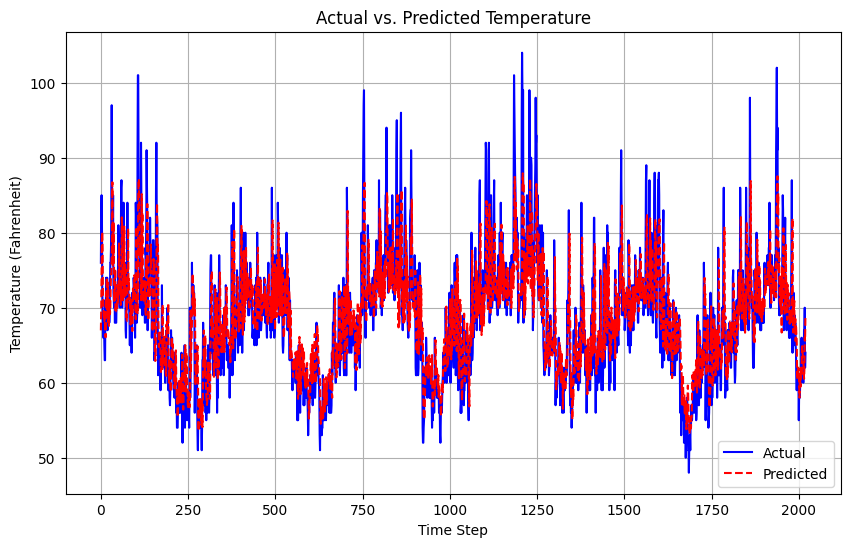

In [41]:
# Convert the predictions and actual temperature to numpy arrays
predictions = np.array(predictions)
actual_values = test_y[sequence_len:]

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Temperature (Fahrenheit)')
plt.title('Actual vs. Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()

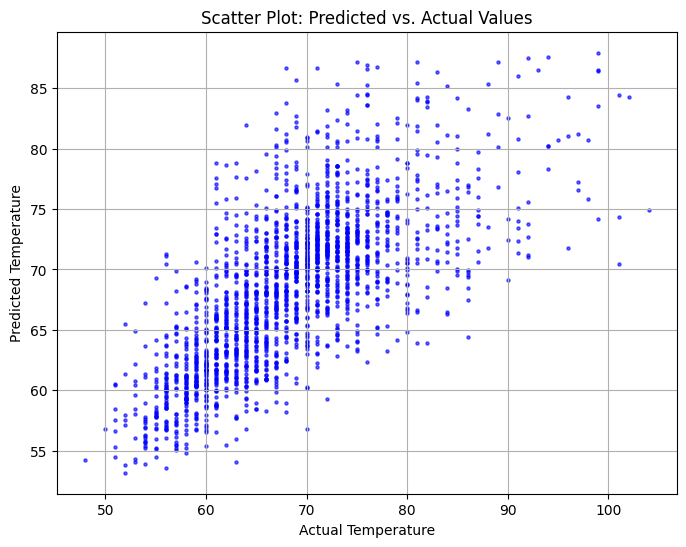

In [42]:
# Plot the scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions, color='b', alpha=0.6,s=5)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Scatter Plot: Predicted vs. Actual Values')
plt.grid(True)
plt.show()

## Exercise
1. In the above code, we made predictions on 7 days of weather data. If you want to make predictions using 14 days of weather data, is it possible? what needs to be changed for our RNN model or the training process?
2. A) In the above code, our RNN input layer have size of 3 and hidden layer of size 4. Can we change these numbers? Why?
```layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1, "units":1}
]
```
2. B) change these numbers and write done what happened.
3. In the above code, we trained our RNN with 150 epochs. During epoch 0 to 50, the loss decreased by more than 3000, meaning our model improved a lot. However, during epoch 60 to 150, the loss only decreased by 1, meaning the model did NOT got better. This means we are wasting time and computation resource. We can stop early once the loss stopped decreasing. Please write code to stop the training when the current cost hasn’t decreased, or only decreased a little bit (<5) compared to the previous cost. Make the change below.

In [ ]:
epoch_count = 150
lr = 1e-5


for epoch in range(epoch_count): # repeat 200 times
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        # make the sequence slices
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]

        # perform forward propagation
        hiddens, outputs = forward(seq_x, layers)

        # calculate gradient and perform gradient descent
        grad = mse_gradient(seq_y, outputs)
        backward(layers, seq_x, lr, grad, hiddens)

        # add up the loss. This is unncessary for training. It is only used for viewing progress of the model trainining
        epoch_loss += mse(seq_y, outputs)

    # run for every 50 times:
    if epoch % 10 == 0 or epoch==epoch_count-1:
        # calculate MSE loss
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            hiddens, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")


## References
- https://github.com/gy910210/rnn-from-scratch
- https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/rnn.ipynb
